In [21]:
! pip install adjustText

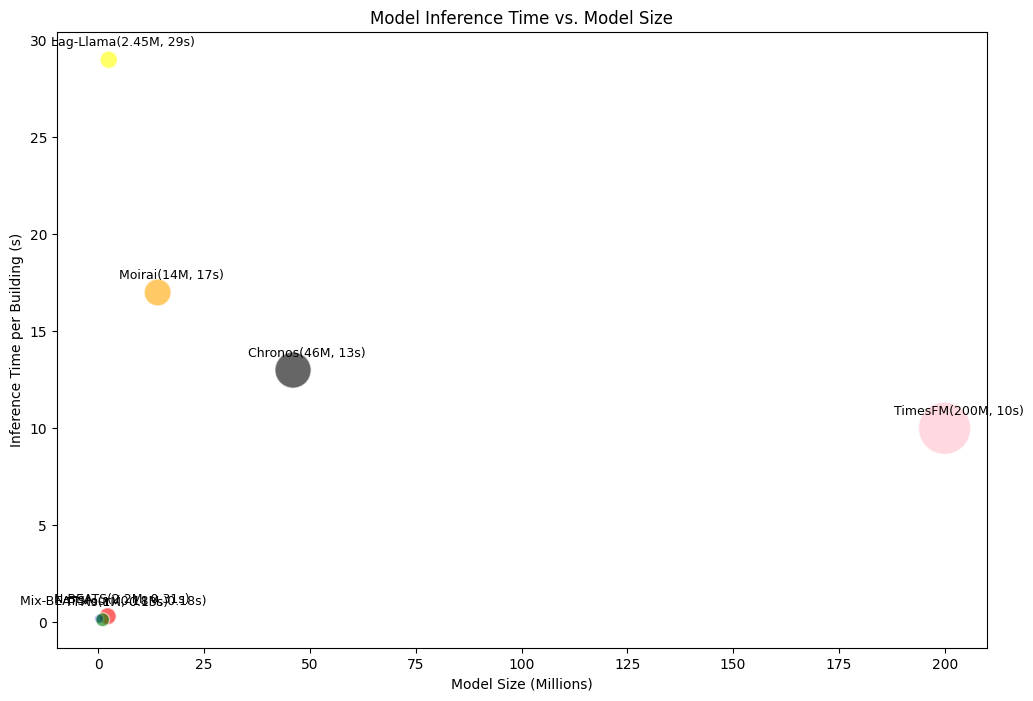

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # To handle overlapping annotations

# Sample data
model_names = ['N-BEATS', 'Mix-BEATS(our)', 'TTMs', 'Moirai', 'Chronos', 'TimesFM', 'Lag-Llama']
cpu_inference_times = [0.31, 0.18, 0.13, 17, 13, 10, 29]  # CPU inference times for each model (in seconds)
model_sizes = [2.2, 0.18, 1, 14, 46, 200, 2.45]  # Model sizes in millions
colors = ['red', 'blue', 'green', 'orange', 'black', 'pink', 'yellow']  # Color for each model

# Convert model sizes to millions for the x-axis
model_sizes_million = np.array(model_sizes)

# Create a plot
plt.figure(figsize=(12, 8))

# Scatter plot with bubble size as model size
scatter = plt.scatter(
    model_sizes_million, cpu_inference_times,
    s=np.sqrt(model_sizes) * 100,  # Bubble size corresponds to model size (scaled for better visualization)
    c=colors,                      # Color each model differently
    alpha=0.6,                     # Set transparency of bubbles
    edgecolors="w",                # White border for bubbles
    linewidth=1,                   # Line width for the edge of the bubbles
    marker='o'                     # Set the marker style
)

# Add labels and title
plt.xlabel('Model Size (Millions)')
plt.ylabel('Inference Time per Building (s)')
plt.title('Model Inference Time vs. Model Size')

# Annotate each point with model name and its inference time
annotations = []
for i, model_name in enumerate(model_names):
    text = plt.annotate(
        f'{model_name}({model_sizes[i]}M, {cpu_inference_times[i]}s)',
        (model_sizes_million[i], cpu_inference_times[i]),
        textcoords="offset points",
        xytext=(10, 10),  # Initial offset
        ha='center',
        fontsize=9
    )
    annotations.append(text)

# Use adjustText to avoid overlapping annotations
# adjust_text(annotations, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# Adjust plot limits to prevent annotations from going out of bounds
# plt.xlim(min(model_sizes_million) - 5, max(model_sizes_million) + 20)
# plt.ylim(min(cpu_inference_times) - 5, max(cpu_inference_times) + 10)

# Show plot
plt.tight_layout()
plt.show()


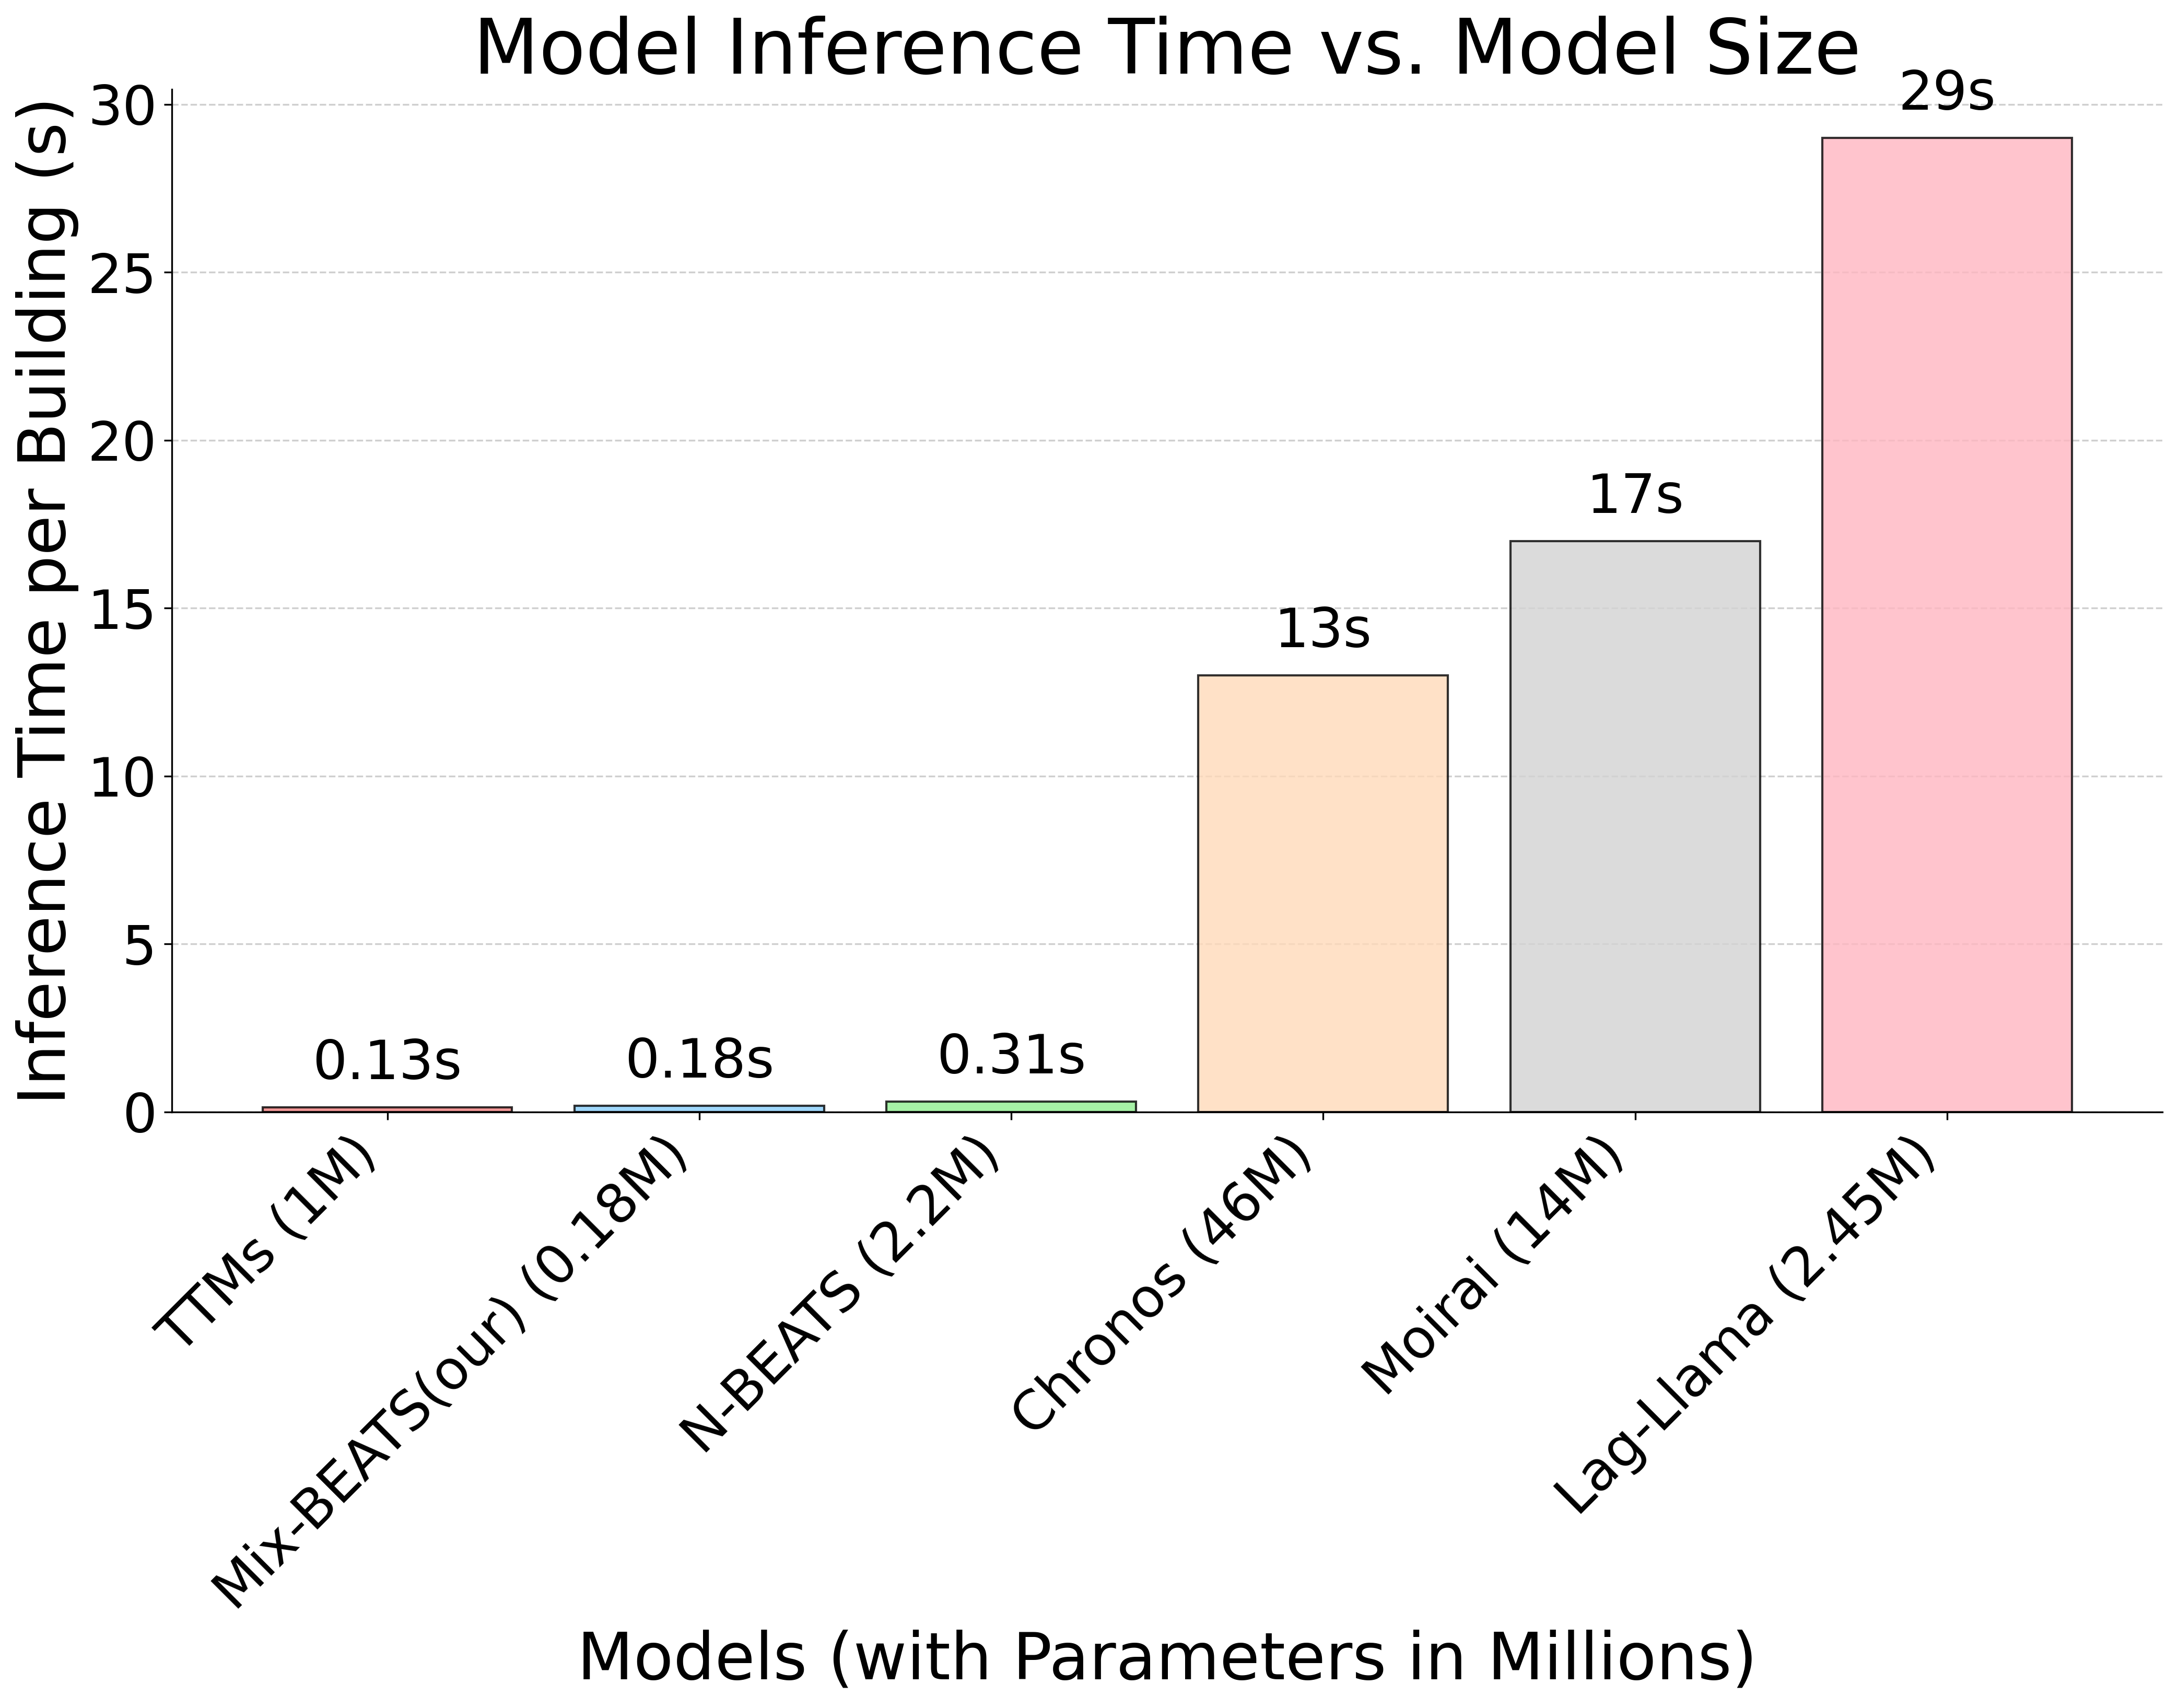

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data


model_names = ['TTMs', 'Mix-BEATS(our)', 'N-BEATS', 'Chronos',  'Moirai', 'Lag-Llama']
cpu_inference_times = [0.13, 0.18, 0.31, 13, 17, 29]
model_sizes = [1, 0.18, 2.2, 46, 14, 2.45]
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'peachpuff', 'lightgray', 'lightpink', 'khaki']  # Color for each model

# Combine model names with parameters for x-axis labels
x_labels = [f"{model_names[i]} ({model_sizes[i]}M)" for i in range(len(model_names))]

# Create a bar plot with larger DPI and font sizes
plt.figure(figsize=(14, 11), dpi=300)  # Increased DPI and dimensions

bars = plt.bar(x_labels, cpu_inference_times, color=colors, alpha=0.8, edgecolor='black')

# Add values above each bar (inference time)
for bar, time in zip(bars, cpu_inference_times):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate at the center of the bar
        bar.get_height() + 0.5,            # y-coordinate slightly above the bar
        f"{time}s",                        # Text to display (inference time)
        ha='center', va='bottom', fontsize=25  # Increased font size
    )


ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)  # Remove the top border
ax.spines['right'].set_visible(False)  # Remove the right border
ax.yaxis.grid(True, linestyle='--', alpha=0.6)  # Add horizontal gridlines
ax.set_axisbelow(True)  

# Add labels and title
plt.xlabel('Models (with Parameters in Millions)', fontsize=30)  # Increased font size
plt.ylabel('Inference Time per Building (s)', fontsize=30)      # Increased font size
plt.title('Model Inference Time vs. Model Size', fontsize=35)   # Increased font size

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=25)  # Increased font size
plt.yticks(fontsize=25)                           # Increased font size

# Adjust layout for better spacing
plt.tight_layout()

# Save as a high-resolution image and vector file
plt.savefig("./plots/inference_time_vs_model_size_high_res.png", dpi=300)  # High-res PNG
plt.savefig("./plots/inference_time_vs_model_size_high_res.pdf")           # Vector PDF

# Show plot
plt.show()


#### Check inference time

In [1]:
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('./model')

import torch
from torch.utils.data import Dataset, DataLoader
from model.mix_beats import NBeatsNet
from torch.utils.data import ConcatDataset

from tqdm import tqdm
# from sklearn.metrics import mean_squared_error



# metrics used for evaluation
def cal_cvrmse(pred, true, eps=1e-8):
    pred = np.array(pred)
    true = np.array(true)
    return np.power(np.square(pred - true).sum() / pred.shape[0], 0.5) / (true.sum() / pred.shape[0] + eps)

def cal_mae(pred, true):
    pred = np.array(pred)
    true = np.array(true)
    return np.mean(np.abs(pred - true))

def cal_nrmse(pred, true, eps=1e-8):
    true = np.array(true)
    pred = np.array(pred)

    M = len(true) // 24
    y_bar = np.mean(true)
    NRMSE = 100 * (1/ (y_bar+eps)) * np.sqrt((1 / (24 * M)) * np.sum((true - pred) ** 2))
    return NRMSE








def standardize_series(series, eps=1e-8):
    mean = np.mean(series)
    std = np.std(series)
    standardized_series = (series - mean) / (std+eps)
    return standardized_series, mean, std

def unscale_predictions(predictions, mean, std, eps=1e-8):
    return predictions * (std+eps) + mean


class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length, stride=1):
        # Standardize the time series data
        self.data, self.mean, self.std = standardize_series(data)
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.stride = stride

    def __len__(self):
        return (len(self.data) - self.backcast_length - self.forecast_length) // self.stride + 1

    def __getitem__(self, index):
        start_index = index * self.stride
        x = self.data[start_index : start_index + self.backcast_length]
        y = self.data[start_index + self.backcast_length : start_index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)




In [7]:
from time import time

# Parameters
backcast_length = 168
forecast_length = 24
stride = 24
batch_size = 64

# Load datasets

# Create data loaders


patch_size = 8 
num_patches = backcast_length // patch_size

# check device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

st = time()

model = NBeatsNet(
    device=device,
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    patch_size = patch_size, 
    num_patches = num_patches,
    hidden_dim=256
).to(device)

model.load_state_dict(torch.load('./model_weights/mix_beats/best_model.pth'))
#  Define loss and optimizer
criterion = torch.nn.MSELoss()



file_path = './dataset/test/Enernoc/enernoc_304.csv'
df = pd.read_csv(file_path)
energy_data = df['energy'].values
dataset = TimeSeriesDataset(energy_data, backcast_length, forecast_length, stride)

building_id = '304'
# test phase
model.eval()

val_losses = []
y_true_test = []
y_pred_test = []

# test loop
for x_test, y_test in tqdm(DataLoader(dataset, batch_size=1), desc=f"Testing {building_id}", leave=False):
    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():
        backcast, forecast = model(x_test)
        loss = criterion(forecast, y_test)
        val_losses.append(loss.item())
        
        # Collect true and predicted values for RMSE calculation
        y_true_test.extend(y_test.cpu().numpy())
        y_pred_test.extend(forecast.cpu().numpy())
        
# Calculate average validation loss and RMSE
y_true_combine = np.concatenate(y_true_test, axis=0)
y_pred_combine = np.concatenate(y_pred_test, axis=0)
avg_test_loss = np.mean(val_losses)

y_pred_combine_unscaled = unscale_predictions(y_pred_combine, dataset.mean, dataset.std)
y_true_combine_unscaled = unscale_predictions(y_true_combine, dataset.mean, dataset.std)

# Calculate CVRMSE, NRMSE, MAE on unscaled data

et = time() - st

print(et,'sec')

print(len(y_pred_combine_unscaled), len(y_true_combine_unscaled))




/tmp/ipykernel_1739991/4220443345.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model_weights/mix_beats/best_model.pth'))
Testing 

0.18085217475891113 sec
8616 8616


In [8]:
import pandas as pd
from datetime import datetime, timedelta

# Example input lists (replace these with your actual lists of size 8616)
y_true = y_true_combine_unscaled
y_pred = y_pred_combine_unscaled
# Ensure both lists have the same size
assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"

# Start timestamp and building name
start_time = datetime.strptime("2020-01-08 00:00:00", "%Y-%m-%d %H:%M:%S")
building = "304"

# Generate timestamps
timestamps = [start_time + timedelta(hours=i) for i in range(len(y_true))]

# Create a DataFrame
data = {
    "timestamp": timestamps,
    "y_true": y_true,
    "y_pred": y_pred,
    "building": [building] * len(y_true),
}

df = pd.DataFrame(data)

# Save to CSV
output_file = "predictions_result/enernoc_304.csv"
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")


Data saved to predictions_result/enernoc_304.csv


In [10]:
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('./model')

import torch
from torch.utils.data import Dataset, DataLoader
from model.nbeats import NBeatsNet
from torch.utils.data import ConcatDataset

from tqdm import tqdm
# from sklearn.metrics import mean_squared_error



# metrics used for evaluation
def cal_cvrmse(pred, true, eps=1e-8):
    pred = np.array(pred)
    true = np.array(true)
    return np.power(np.square(pred - true).sum() / pred.shape[0], 0.5) / (true.sum() / pred.shape[0] + eps)

def cal_mae(pred, true):
    pred = np.array(pred)
    true = np.array(true)
    return np.mean(np.abs(pred - true))

def cal_nrmse(pred, true, eps=1e-8):
    true = np.array(true)
    pred = np.array(pred)

    M = len(true) // 24
    y_bar = np.mean(true)
    NRMSE = 100 * (1/ (y_bar+eps)) * np.sqrt((1 / (24 * M)) * np.sum((true - pred) ** 2))
    return NRMSE








def standardize_series(series, eps=1e-8):
    mean = np.mean(series)
    std = np.std(series)
    standardized_series = (series - mean) / (std+eps)
    return standardized_series, mean, std

def unscale_predictions(predictions, mean, std, eps=1e-8):
    return predictions * (std+eps) + mean


class TimeSeriesDataset(Dataset):
    def __init__(self, data, backcast_length, forecast_length, stride=1):
        # Standardize the time series data
        self.data, self.mean, self.std = standardize_series(data)
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.stride = stride

    def __len__(self):
        return (len(self.data) - self.backcast_length - self.forecast_length) // self.stride + 1

    def __getitem__(self, index):
        start_index = index * self.stride
        x = self.data[start_index : start_index + self.backcast_length]
        y = self.data[start_index + self.backcast_length : start_index + self.backcast_length + self.forecast_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)




In [13]:
from time import time

# Parameters
backcast_length = 168
forecast_length = 24
stride = 24
batch_size = 64

# Load datasets

# Create data loaders


patch_size = 8 
num_patches = backcast_length // patch_size

# check device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

st = time()

model = NBeatsNet(
    device=device,
    forecast_length=forecast_length,
    backcast_length=backcast_length,
).to(device)

model.load_state_dict(torch.load('./model_weights/nbeats/best_model.pth'))
#  Define loss and optimizer
criterion = torch.nn.MSELoss()



file_path = './dataset/test/Bareilly/Bareilly_2020_BR33.csv'
df = pd.read_csv(file_path)
energy_data = df['energy'].values
dataset = TimeSeriesDataset(energy_data, backcast_length, forecast_length, stride)

building_id = 'BR33'
# test phase
model.eval()

val_losses = []
y_true_test = []
y_pred_test = []

# test loop
for x_test, y_test in tqdm(DataLoader(dataset, batch_size=1), desc=f"Testing {building_id}", leave=False):
    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():
        backcast, forecast = model(x_test)
        loss = criterion(forecast, y_test)
        val_losses.append(loss.item())
        
        # Collect true and predicted values for RMSE calculation
        y_true_test.extend(y_test.cpu().numpy())
        y_pred_test.extend(forecast.cpu().numpy())
        
# Calculate average validation loss and RMSE
y_true_combine = np.concatenate(y_true_test, axis=0)
y_pred_combine = np.concatenate(y_pred_test, axis=0)
avg_test_loss = np.mean(val_losses)

y_pred_combine_unscaled = unscale_predictions(y_pred_combine, dataset.mean, dataset.std)
y_true_combine_unscaled = unscale_predictions(y_true_combine, dataset.mean, dataset.std)

# Calculate CVRMSE, NRMSE, MAE on unscaled data

et = time() - st

print(et,'sec')

print(len(y_pred_combine_unscaled), len(y_true_combine_unscaled))




/tmp/ipykernel_1739991/1852767306.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model_weights/nbeats/best_model.pth'))


| N-Beats


0.30261754989624023 sec
8616 8616


In [14]:
import pandas as pd
from datetime import datetime, timedelta

# Example input lists (replace these with your actual lists of size 8616)
y_true = y_true_combine_unscaled
y_pred = y_pred_combine_unscaled
# Ensure both lists have the same size
assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"

# Start timestamp and building name
start_time = datetime.strptime("2020-01-08 00:00:00", "%Y-%m-%d %H:%M:%S")
building = "BR33"

# Generate timestamps
timestamps = [start_time + timedelta(hours=i) for i in range(len(y_true))]

# Create a DataFrame
data = {
    "timestamp": timestamps,
    "y_true": y_true,
    "y_pred": y_pred,
    "building": [building] * len(y_true),
}

df = pd.DataFrame(data)

# Save to CSV
output_file = "predictions_result/bareilly_br33_nbeats.csv"
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")


Data saved to predictions_result/bareilly_br33_nbeats.csv


In [8]:
# import matplotlib.pyplot as plt

# # Sample data (replace these with your actual MSE loss results)
# patch_lengths = [4, 8, 12, 24]
# seq_lengths = [96, 168, 336, 720]
# hidden_dims = [128, 256, 512, 1024]
# strides = [1, 2, 4, 8, 12, 24]

# # Replace these with actual values from your experiments
# mse_patch = [0.164, 0.165, 0.165, 0.165]
# mse_seq = [0.170, 0.164, 0.160, 0.158]
# mse_hidden = [0.165, 0.164, 0.163, 0.162]
# mse_stride = [0.156, 0.157, 0.159, 0.161, 0.162, 0.164]

# # Create 2x2 grid of plots
# fig, axs = plt.subplots(2, 2, figsize=(14, 10))
# # fig.suptitle('Hyperparameter Impact on MSE Loss', fontsize=16)

# # Patch Length vs MSE
# axs[0, 0].plot(patch_lengths, mse_patch, marker='o')
# axs[0, 0].set_title('Patch Length vs MSE')
# axs[0, 0].set_xlabel('Patch Length')
# axs[0, 0].set_ylabel('MSE Loss')

# # Sequence Length vs MSE
# axs[0, 1].plot(seq_lengths, mse_seq, marker='o', color='orange')
# axs[0, 1].set_title('Sequence Length vs MSE')
# axs[0, 1].set_xlabel('Sequence Length')
# axs[0, 1].set_ylabel('MSE Loss')

# # Hidden Dimension vs MSE
# axs[1, 0].plot(hidden_dims, mse_hidden, marker='o', color='green')
# axs[1, 0].set_title('Hidden Dimension vs MSE')
# axs[1, 0].set_xlabel('Hidden Dim')
# axs[1, 0].set_ylabel('MSE Loss')

# # Stride vs MSE
# axs[1, 1].plot(strides, mse_stride, marker='o', color='red')
# axs[1, 1].set_title('Stride vs MSE')
# axs[1, 1].set_xlabel('Stride')
# axs[1, 1].set_ylabel('MSE Loss')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("./plots/hyperparameters_sensitivity.pdf", dpi=300)
# plt.show()



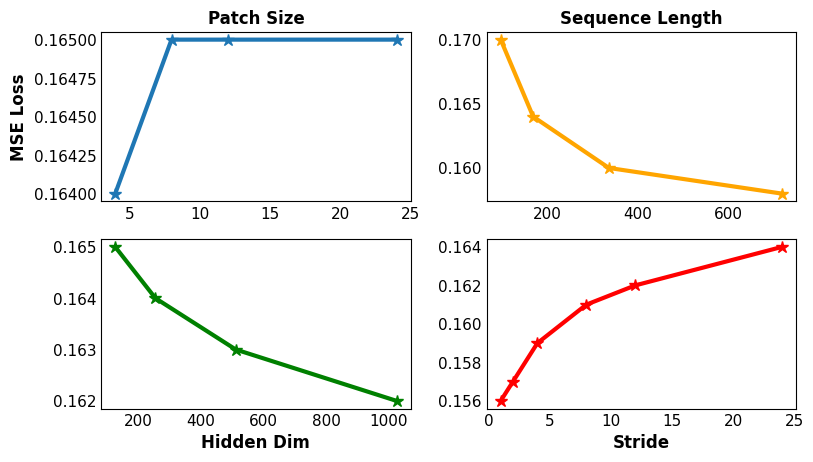

In [155]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual MSE loss results)
patch_sizes = [4, 8, 12, 24]
seq_lengths = [96, 168, 336, 720]
hidden_dims = [128, 256, 512, 1024]
strides = [1, 2, 4, 8, 12, 24]

# Replace these with actual values from your experiments
mse_patch = [0.164, 0.165, 0.165, 0.165]
mse_seq = [0.170, 0.164, 0.160, 0.158]
mse_hidden = [0.165, 0.164, 0.163, 0.162]
mse_stride = [0.156, 0.157, 0.159, 0.161, 0.162, 0.164]

# Increase font sizes globally
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 14,
    'lines.linewidth': 3,
    'lines.markersize': 9,
    # 'axes.titleweight': 'bold',
    # 'axes.labelweight': 'bold',
    # 'xtick.weight': 'bold',
    # 'ytick.weight': 'bold'
})

# Create 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(8.3, 5.2))


# Patch Size vs MSE
axs[0, 0].plot(patch_sizes, mse_patch, marker='*')
axs[0, 0].set_title('Patch Size')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('')
axs[0, 0].set_ylabel('MSE Loss')
axs[0, 0].tick_params(axis='both', length=0)  

# Sequence Length vs MSE
axs[0, 1].plot(seq_lengths, mse_seq, marker='*', color='orange')
axs[0, 1].set_title('Sequence Length')
axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', length=0)  
# Hidden Dimension vs MSE
axs[1, 0].plot(hidden_dims, mse_hidden, marker='*', color='green')
axs[1, 0].set_title('')
axs[1, 0].set_xlabel('Hidden Dim')
axs[1, 0].set_ylabel('')
axs[1, 0].tick_params(axis='both', length=0)  

# Stride vs MSE
axs[1, 1].plot(strides, mse_stride, marker='*', color='red')
axs[1, 1].set_title('')
axs[1, 1].set_xlabel('Stride')
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', length=0)  

# Adjust layout and save high-quality figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./plots/hyperparameters_sensitivity.pdf", dpi=600, bbox_inches='tight')  # high DPI for quality
plt.show()


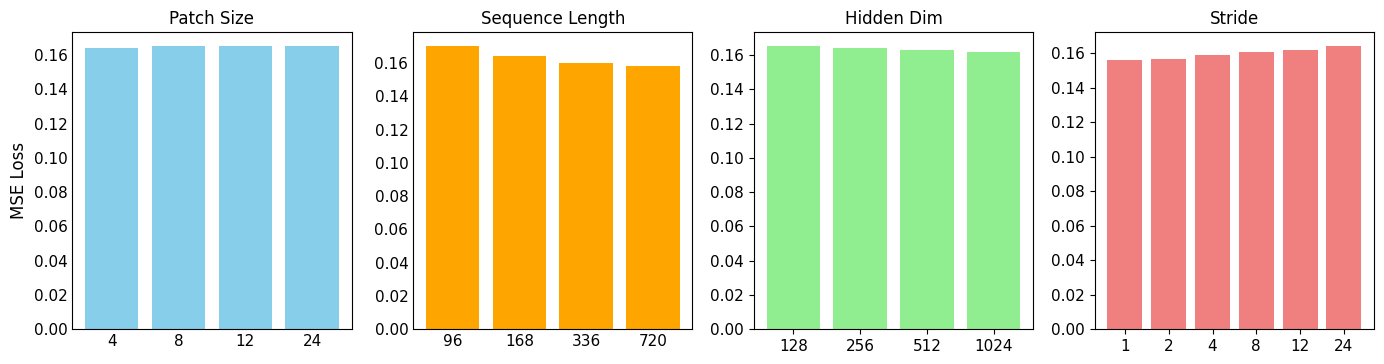

In [1]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual MSE loss results)
patch_sizes = [4, 8, 12, 24]
seq_lengths = [96, 168, 336, 720]
hidden_dims = [128, 256, 512, 1024]
strides = [1, 2, 4, 8, 12, 24]

# Replace these with actual values from your experiments
mse_patch = [0.164, 0.165, 0.165, 0.165]
mse_seq = [0.170, 0.164, 0.160, 0.158]
mse_hidden = [0.165, 0.164, 0.163, 0.162]
mse_stride = [0.156, 0.157, 0.159, 0.161, 0.162, 0.164]

# Update font sizes globally
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 14,
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Create 1x4 grid of bar plots
fig, axs = plt.subplots(1, 4, figsize=(14, 3.8))

# Patch Size
axs[0].bar([str(p) for p in patch_sizes], mse_patch, color='skyblue')
axs[0].set_title("Patch Size")
axs[0].set_xlabel("")
axs[0].set_ylabel("MSE Loss")
axs[0].tick_params(axis='both', length=0)

# Sequence Length
axs[1].bar([str(s) for s in seq_lengths], mse_seq, color='orange')
axs[1].set_title("Sequence Length")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].tick_params(axis='both', length=0)

# Hidden Dimension
axs[2].bar([str(h) for h in hidden_dims], mse_hidden, color='lightgreen')
axs[2].set_title("Hidden Dim")
axs[2].set_xlabel("")

# Stride
axs[3].bar([str(s) for s in strides], mse_stride, color='lightcoral')
axs[3].set_title("Stride")
axs[3].set_xlabel("")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("./plots/hyperparameters_sensitivity_bar.pdf", dpi=600, bbox_inches='tight')
plt.show()


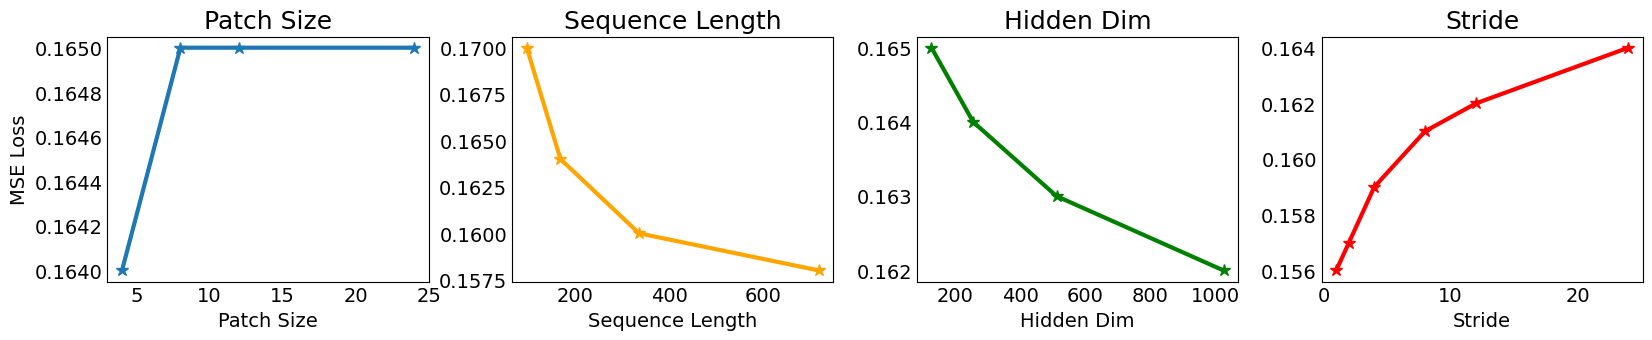

In [134]:
import matplotlib.pyplot as plt

# Sample data
patch_sizes = [4, 8, 12, 24]
seq_lengths = [96, 168, 336, 720]
hidden_dims = [128, 256, 512, 1024]
strides = [1, 2, 4, 8, 12, 24]

mse_patch = [0.164, 0.165, 0.165, 0.165]
mse_seq = [0.170, 0.164, 0.160, 0.158]
mse_hidden = [0.165, 0.164, 0.163, 0.162]
mse_stride = [0.156, 0.157, 0.159, 0.161, 0.162, 0.164]

# Global font settings
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'lines.linewidth': 3,
    'lines.markersize': 9
})

# 1x4 horizontal subplots for paper layout
fig, axs = plt.subplots(1, 4, figsize=(16.51, 3.5))  # Full page width in IEEE format


# Plotting each graph
axs[0].plot(patch_sizes, mse_patch, marker='*')
axs[0].set_title('Patch Size')
axs[0].set_xlabel('Patch Size')
axs[0].set_ylabel('MSE Loss')
axs[0].tick_params(axis='both', length=0)  

axs[1].plot(seq_lengths, mse_seq, marker='*', color='orange')
axs[1].set_title('Sequence Length')
axs[1].set_xlabel('Sequence Length')
axs[1].set_ylabel('')
axs[1].tick_params(axis='both', length=0)  

axs[2].plot(hidden_dims, mse_hidden, marker='*', color='green')
axs[2].set_title('Hidden Dim')
axs[2].set_xlabel('Hidden Dim')
axs[2].set_ylabel('')
axs[2].tick_params(axis='both', length=0)  

axs[3].plot(strides, mse_stride, marker='*', color='red')
axs[3].set_title('Stride')
axs[3].set_xlabel('Stride')
axs[3].set_ylabel('')
axs[3].tick_params(axis='both', length=0)  

# Improve spacing
fig.subplots_adjust(wspace=0.26, left=0.05, right=0.98, top=0.92, bottom=0.22)

# Save figure
plt.savefig("./plots/hyperparameters_sensitivity.pdf", dpi=600, bbox_inches='tight')
plt.show()


### Draw Figure

In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error

def NRMSE(true, pred):

    true_values = np.array(true)
    predicted_values = np.array(pred)
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

    # Normalize RMSE by the range of true values
    nrmse = rmse / np.average(true_values)

    return (nrmse * 100).round(2)

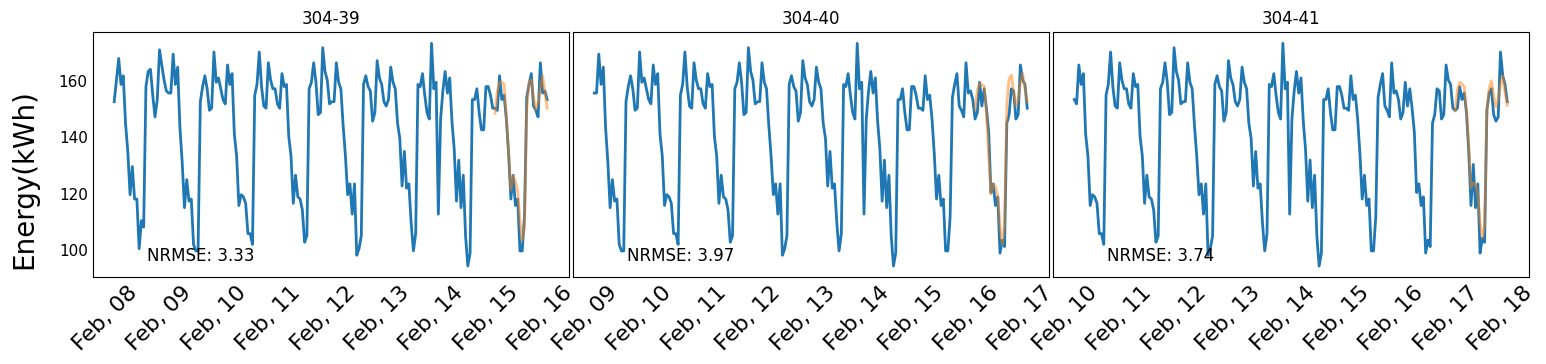

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

window = [39, 40, 41]
time_window = ["2020-02-09","2020-02-10","2020-02-11"]

df = pd.read_csv("./predictions_result/enernoc_304.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

start_idx = 744

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16.51, 3.5))

for i, ax in enumerate(axs):

    # Simulate data

    small_df = df.iloc[start_idx + i*24 : start_idx + i*24 + 192]
    dt = (i+8)
    time = pd.date_range(start=time_window[i], periods=192, freq='h')
    true = small_df["y_true"]
    pred = [None] * 168 + small_df["y_pred"][-24:].tolist()

    nrmse = NRMSE(true[-24:], pred[-24:])
    # print("nrmse score is :", nrmse)
    building_id = 304


    ax.plot(time, true, label='')  # Actual
    ax.plot(time, pred, label='', alpha=0.5)  # Forecast (Mix-BEATS)
    ax.text(0.34, 0.05, f'NRMSE: {nrmse:.2f}',
        transform=ax.transAxes,
        # fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='right')
    
    locator = mdates.HourLocator(interval=24)
    formatter = mdates.DateFormatter('%b, %d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    # ax.set_xlabel("Date")
    ax.set_title(f"{building_id}-{window[i]}")
    ax.tick_params(axis='x', labelsize=16, rotation=45)
    ax.tick_params(axis='both', length=0)  

    if i > 0:
        ax.set_yticklabels([])  # hide tick labels
        ax.set_ylabel("")
        # ax.spines['left'].set_visible(False)  # Remove left spine


# Set shared y-axis label
fig.text(0.06, 0.5, 'Energy(kWh)', va='center', rotation='vertical', fontsize=20)
# fig.suptitle("True vs Predicted Energy (168h true + 24h predicted)", fontsize=14)
# axs[0].legend(loc='upper left')
fig.subplots_adjust(left=0.11, right=0.98, top=0.92, bottom=0.22, wspace=0.008)
# plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.savefig("./plots/Enernoc.pdf", dpi=600)
plt.show()

